In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import pickle
import networkx as nx

In [57]:
font = {'family' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

In [2]:
# The network with the GRN
df = pd.read_csv('../../CAR_data/Network_with_GRN.tsv', sep = "\t", header=None)
df.columns = ["source", "target", "weight"]
Graphtype = nx.DiGraph()
G_GRN= nx.from_pandas_edgelist(df, create_using=Graphtype)
#nx.draw(G_GRN)

In [3]:
# The network without the GRN
df = pd.read_csv('../../CAR_data/Network_without_GRN.tsv', sep = "\t", header=None)
df.columns = ["source", "target", "weight"]
Graphtype = nx.DiGraph()
G_noGRN= nx.from_pandas_edgelist(df, create_using=Graphtype)
#nx.draw(G_GRN)

In [4]:
# The depth normalised raw counts
depth_norm = pd.read_csv("../../CAR_data/raw_counts_depth_normalized_genes_of_interest_celltypes.csv", index_col = 0)

In [5]:
# The raw counts bulked by CAR variant and cell type
bulked_df = pd.read_csv("../../CAR_data/raw_counts_bulked_by_CAR_and_celltype.csv", index_col = 0)

In [6]:
TFs = pickle.load(open("../../CAR_data/TF_list", "rb"))

In [7]:
# Nodes in the GRN: TF + nodes downstream of those, that are not in the network without GRN
nodes_GRN = list(np.unique([n for n in G_GRN.nodes() if n not in G_noGRN.nodes()] + TFs))
edges_GRN = [n for n in G_GRN.edges() if n not in G_noGRN.edges()]

# Add the edges in the TF
for tf in TFs:
    s = G_GRN.successors(tf)
    if s in nodes_GRN:
        edges_GRN.add(G.edges[(tf,s)])

For each node in the network, compute the mutual information between this node and its parents

In [8]:
def compute_MI(node, network, values_df):
    """ Compute the mutual information between a node and 
    all of its parents according to the given network topology. """
    
    parents = [p for p in network.predecessors(node)]
    if len(parents) == 0:
        return(None)
    else:
        mi_dict = {}
        for i in range(len(parents)):
            try:
                mi_dict[parents[i]] = float(mutual_info_regression(
                    X = np.array(values_df[parents[i]]).reshape(-1, 1), 
                    y = np.ravel(np.array(values_df[node]).reshape(-1, 1)), 
                    random_state = 2))
            except Exception as e:
                print(e)
        return(mi_dict)




def compute_all_MI(network_no_GRN, network_with_GRN, values_df):
    GRN_MIs = pd.DataFrame(columns = ["Node", "Parents", "MI"])
    no_GRN_MIs = pd.DataFrame(columns = ["Node", "Parents", "MI"])
    
    # Nodes in the GRN: nodes downstream of TF, that are not in the network without GRN
    # The TF are not included, because their parents are not in the GRN
    # but the function compute_MI will fetch the MI between TF and their downstream nodes.
    nodes_GRN = [n for n in G_GRN.nodes() if n not in G_noGRN.nodes()]

    index = 0
    for n in nodes_GRN:
        MI = compute_MI(n, network_with_GRN, values_df)
        if MI is not None:
            for p, mi in MI.items():
                GRN_MIs.loc[index, "Node"] = n
                GRN_MIs.loc[index, "Parents"] = p
                GRN_MIs.loc[index, "MI"] = mi
                index += 1
    
    index = 0
    for n in network_no_GRN.nodes():
        MI = compute_MI(n, network_no_GRN, values_df)
        if MI is not None:
            for p, mi in MI.items():
                no_GRN_MIs.loc[index, "Node"] = n
                no_GRN_MIs.loc[index, "Parents"] = p
                no_GRN_MIs.loc[index, "MI"] = mi
                index += 1
    
    return(GRN_MIs, no_GRN_MIs)

In [9]:
GRN_MIs, no_GRN_MIs = compute_all_MI(network_no_GRN=G_noGRN, network_with_GRN=G_GRN, values_df=depth_norm )

'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'NFkB'
'AP1'
'AP1'
'NFkB'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'STAT35'
'TRAF12'
'TRAF12'
'STAT35'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'TRAF12'
'TRAF12'
'TRAF23'
'TRAF23'
'TRAF23'
'STAT35'
'STAT35'
'STAT35'


In [10]:
GRN_MIs

,Node,Parents,MI
0,IL10,STAT3,0.010468
1,IL10,E2F4,0.011559
2,IL10,JUND,0.010602
3,IL10,STAT5A,0.002929
4,IL10,MYC,0.001582
...,...,...,...
799,GZMA,ETS1,0.046975
800,GZMA,REST,0.053328
801,CD3E,GATA1,0.002007
802,CD3E,GATA2,0.002294


In [11]:
no_GRN_MIs

,Node,Parents,MI
0,PI3K,CD28,0.460259
1,PI3K,Grb2,0.556552
2,PI3K,41BB,0.147626
3,PI3K,TRAF6,0.074544
4,PI3K,CTLA4,0.283719
5,Lck,CD28,0.353947
6,Lck,CD45,0.299751
7,Grb2,CD28,0.535431
8,Grb2,CD3z,0.867901
9,Grb2,Shc,0.278183


I do not know the standard deviationi of the underlying distribution -> ttest
https://vitalflux.com/when-to-use-z-test-vs-t-test-differences-examples/

My samples are probably related? so I'll use the ttest for related samples

In [12]:
from scipy.stats import ttest_rel, ttest_ind, kstest

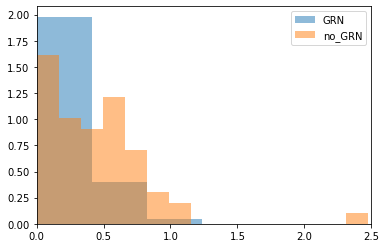

In [13]:
plt.hist(GRN_MIs["MI"], density = True, alpha = 0.5,  label = "GRN", bins = 15)
plt.hist(no_GRN_MIs["MI"], density = True, alpha = 0.5, label = "no_GRN", bins = 15)
plt.xlim([0,2.5])
plt.legend()
plt.show()

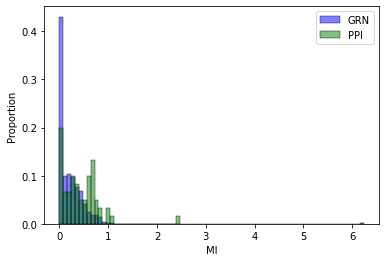

In [14]:
fig, ax = plt.subplots()
for a in [(GRN_MIs["MI"], "GRN", "b"), (no_GRN_MIs["MI"], "PPI", "g")]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.5, binwidth=0.08)
plt.legend()

In [15]:
# Standard deviation of te 2 series
print("stdev")
print(GRN_MIs["MI"].std()) # 0.3
print(no_GRN_MIs["MI"].std()) # 0.39
# I guess they are similar

# Mean of the two series
print("mean")
print(GRN_MIs["MI"].mean()) # 0.3
print(no_GRN_MIs["MI"].mean()) # 0.39

stdev
0.30790278086420986
0.3943515791222613
mean
0.21419017229026865
0.4429386057224389


In [16]:
# Are the means of the 2 distributions different?
ttest_ind(a = no_GRN_MIs["MI"], 
         b = GRN_MIs["MI"], 
         alternative = "two-sided", equal_var = False)
# Yes the means are different

Ttest_indResult(statistic=4.394296655381423, pvalue=4.234266158876644e-05)

In [17]:
# Is the mean of the GRN higher?
ttest_ind(a = no_GRN_MIs["MI"], 
         b = GRN_MIs["MI"], 
         alternative = "less", equal_var = False)
# No the mean of the GRN is definitely NOT higher

Ttest_indResult(statistic=4.394296655381423, pvalue=0.9999788286692056)

In [18]:
# Are the 2 samples drawn from the same distribution?
kstest(rvs = no_GRN_MIs["MI"], 
         cdf = GRN_MIs["MI"], 
         alternative = "two-sided")
# The 2 samples are decidedly not from the same distribution

KstestResult(statistic=0.3365671641791045, pvalue=3.900007687872744e-06)

This will need to be compared to the MIs in the DREAM dataset

# Get the correlations on the DREAM dataset

In [19]:
proteom = pd.read_csv("../../nonCAR_data/DREAM/184A1.csv", index_col = 0)
proteom

,cell_line,time,cellID,fileID,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,Ki.67,...,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
treatment,,,,,,,,,,,,,,,,,,,,,
EGF,184A1,0.0,1,2656,0.224784,1.584511,2.41223,1.586472,5.09198,1.59085,...,0.634713,1.998328,6.12288,4.63975,0.331558,2.533238,0.776630,1.24288,0.704653,-0.577393
EGF,184A1,0.0,1,2689,1.595264,3.411190,2.72302,4.005737,5.01509,1.66281,...,3.624425,2.937221,4.46909,4.76504,2.479759,3.402019,3.276655,2.78475,3.121248,2.679670
EGF,184A1,0.0,2,2656,0.951345,2.176985,2.39565,3.483457,5.35645,1.59085,...,2.516105,2.244438,4.77870,4.39714,2.318597,2.055899,1.811624,2.38297,1.422220,2.116090
EGF,184A1,0.0,2,2689,0.922596,0.898342,1.33964,2.602804,4.97583,1.59085,...,2.511926,2.644928,3.96006,6.60913,2.748559,2.647203,2.574775,2.74840,0.975855,2.299180
EGF,184A1,0.0,3,2656,1.973735,2.107103,1.20489,1.560698,4.41617,4.27447,...,2.223099,0.986227,5.40873,5.21624,0.331558,1.853277,1.515975,1.33837,2.242177,0.997212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iPKC,184A1,60.0,8993,2685,0.224784,0.901980,1.20489,1.556061,5.92788,1.59085,...,1.252141,0.986227,5.21381,4.03009,1.376133,0.984362,0.995522,2.15624,2.454229,2.468410
iPKC,184A1,60.0,8994,2685,1.179694,2.766823,2.71353,3.987655,4.25020,2.26050,...,3.003257,3.390107,5.04285,5.17985,2.103239,3.005622,2.389581,3.09924,2.643323,2.516400
iPKC,184A1,60.0,8995,2685,0.713108,2.694621,4.16943,1.032557,11.88808,3.44740,...,1.018298,1.023531,6.01500,3.67270,1.141774,1.457639,1.339209,1.83001,0.842320,1.560530


In [20]:
proteom60 = proteom[proteom["time"]==60]

In [21]:
df = pd.read_csv('../../nonCAR_data/DREAM/prior_knowledge.sif', sep = "\t", header=None)
df.columns = ["source", "weight", "target"]
Graphtype = nx.DiGraph()
PPI_network= nx.from_pandas_edgelist(df, create_using=Graphtype)

In [22]:
# Relate the gene names to the phosphorylated protein name
colnames = [c for c in proteom.columns]
print(colnames)

# Dictionnary of relationships
dico = {}
for node in PPI_network.nodes():
    dico[node] = [c for c in colnames if node in c]
print(dico)

# Manual corrections to the dictionnary
dico["PKA"] = []
dico["AKT"] = []
dico["S6"] = ["p.S6"]
dico["b-catenin"] = "b.CATENIN"
dico["AKT_S473"] = 'p.Akt.Ser473.'
dico["AKT_T308"] = 'p.AKT.Thr308.'
dico["p70S6K"] = "p.S6K"
dico["ERK12"] = "p.ERK"
dico["GSK3B"] = "p.GSK3b"
dico["MAP3Ks"] = "p.MAP2K3"
dico["MEK12"] = 'p.MEK'
dico["MKK36"] = 'p.MKK3.MKK6'

# Extract the name from the list
for key,val in dico.items():
    if isinstance(val, list) and len(val)>0:
        dico[key] = val[0]

# Visualise the mapping
print(dico)

['cell_line', 'time', 'cellID', 'fileID', 'b.CATENIN', 'cleavedCas', 'CyclinB', 'GAPDH', 'IdU', 'Ki.67', 'p.4EBP1', 'p.Akt.Ser473.', 'p.AKT.Thr308.', 'p.AMPK', 'p.BTK', 'p.CREB', 'p.ERK', 'p.FAK', 'p.GSK3b', 'p.H3', 'p.HER2', 'p.JNK', 'p.MAP2K3', 'p.MAPKAPK2', 'p.MEK', 'p.MKK3.MKK6', 'p.MKK4', 'p.NFkB', 'p.p38', 'p.p53', 'p.p90RSK', 'p.PDPK1', 'p.PLCg2', 'p.RB', 'p.S6', 'p.S6K', 'p.SMAD23', 'p.SRC', 'p.STAT1', 'p.STAT3', 'p.STAT5']
{'PIP3': [], 'AKT_S473': [], 'p53': ['p.p53'], 'RB': ['p.RB'], 'GSK3B': [], 'AMPK': ['p.AMPK'], 'cleavedCas': ['cleavedCas'], 'SMAD23': ['p.SMAD23'], 'ERK12': [], 'MSK12': [], 'MKK36': [], 'H3': ['p.H3'], 'p90RSK': ['p.p90RSK'], 'SERUM': [], 'mTOR': [], 'AKT': ['p.AKT.Thr308.'], 'NFkB': ['p.NFkB'], 'cAMP': [], 'PKA': ['p.MAPKAPK2'], 'PKC': [], 'p38': ['p.p38'], 'PLCg2': ['p.PLCg2'], 'MET': [], 'RAF': [], 'p70S6K': [], 'PDPK1': ['p.PDPK1'], 'AKT_T308': [], 'MAPKAPK2': ['p.MAPKAPK2'], 'PTEN': [], 'b-catenin': [], 'S6': ['p.S6', 'p.S6K'], 'CREB': ['p.CREB'], 'R

In [23]:
def get_MIs_phosphoproteomics(phosphoproteomics_df, mapping_dict, prior_network):
    mi_dict_DREAM = {}
    for n in prior_network.nodes():
        if n in mapping_dict: # We only look at the nodes for which we can have the protein activity
            parents = [p for p in prior_network.predecessors(n)]
            print(n, parents)
            for i in range(len(parents)):
                node = mapping_dict[n]
                try:
                    # Do we have the expression for the parent?
                    parent = mapping_dict[parents[i]]
                    # Compute the MI
                    mi_dict_DREAM[(parent, node)] = float(mutual_info_regression(
                            X = np.array(phosphoproteomics_df[parent]).reshape(-1, 1), 
                            y = np.array(phosphoproteomics_df[node]), 
                            random_state = 2))
                except Exception as e:
                    print(e) 
    DREAM_MI = pd.DataFrame.from_dict(mi_dict_DREAM, orient="index")
    DREAM_MI.columns = ["MI"]
    DREAM_MI["parent"] = DREAM_MI.index
    DREAM_MI.reset_index()
    return(DREAM_MI)

In [24]:
DREAM_MI = get_MIs_phosphoproteomics(phosphoproteomics_df=proteom,
                                    mapping_dict=dico,
                                    prior_network=PPI_network)

PIP3 ['PTEN', 'PI3K']
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
AKT_S473 ['PIP3', 'mTOR']
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
p53 ['p38']
RB ['p53', 'GSK3B', 'AMPK']
GSK3B ['PKC', 'AKT']
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
AMPK ['SERUM']
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
cleavedCas ['p53', 'SMAD23']
SMAD23 ['SERUM']
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
ERK12 ['MEK12', 'FAK']
MSK12 ['ERK12', 'MKK36', 'p38']
y should be a 1d array, got an array of shape (372378, 0) instead.
y should be a 1d array, got an array of shape (372378, 0) instead.
y should be a 1d 

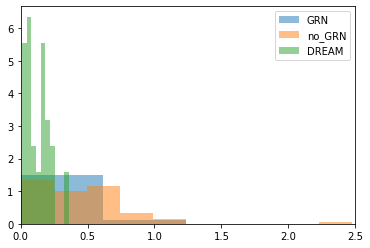

In [25]:
plt.hist(GRN_MIs["MI"], density = True, alpha = 0.5,  label = "GRN")
plt.hist(no_GRN_MIs["MI"], density = True, alpha = 0.5, label = "no_GRN")
plt.hist(DREAM_MI["MI"], density = True, alpha = 0.5, label = "DREAM")
plt.xlim([0,2.5])
plt.legend()
plt.show()

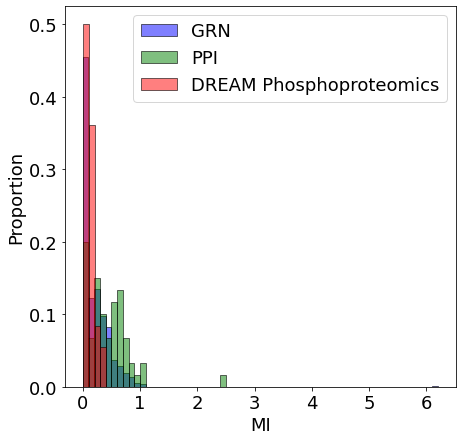

In [59]:
fig, ax = plt.subplots(figsize = (7,7))
for a in [(GRN_MIs["MI"], "GRN", "b"), (no_GRN_MIs["MI"], "PPI", "g"),
          (DREAM_MI["MI"], "DREAM Phosphoproteomics", "r")]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.5, binwidth=0.1)
plt.legend()

PIP3 ['PTEN', 'PI3K']
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
AKT_S473 ['PIP3', 'mTOR']
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
p53 ['p38']
RB ['p53', 'GSK3B', 'AMPK']
GSK3B ['PKC', 'AKT']
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
AMPK ['SERUM']
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
cleavedCas ['p53', 'SMAD23']
SMAD23 ['SERUM']
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
ERK12 ['MEK12', 'FAK']
MSK12 ['ERK12', 'MKK36', 'p38']
y should be a 1d array, got an array of shape (34932, 0) instead.
y should be a 1d array, got an array of shape (34932, 0) instead.
y should be a 1d ar

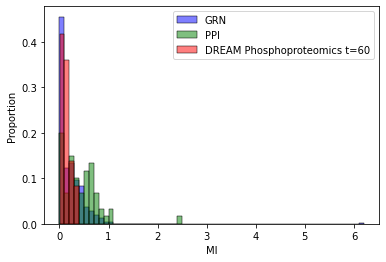

In [27]:
# Look at the correlation if we only look at the steady state
fig, ax = plt.subplots()
DREAM_60_MI = get_MIs_phosphoproteomics(phosphoproteomics_df=proteom[proteom["time"]==60],
                                    mapping_dict=dico,
                                    prior_network=PPI_network)

for a in [(GRN_MIs["MI"], "GRN", "b"), (no_GRN_MIs["MI"], "PPI", "g"),
          (DREAM_60_MI["MI"], "DREAM Phosphoproteomics t=60", "r")]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.5, binwidth=0.1)
plt.legend()

In [28]:
print("Data PPI")
print(no_GRN_MIs["MI"].mean())
print(no_GRN_MIs["MI"].std())

print("Data GRN")
print(GRN_MIs["MI"].mean())
print(GRN_MIs["MI"].std())

print("DREAM MI")
print(DREAM_MI["MI"].mean())
print(DREAM_MI["MI"].std())

Data PPI
0.4429386057224389
0.3943515791222613
Data GRN
0.21419017229026865
0.30790278086420986
DREAM MI
0.12507782945895107
0.08836095560194193


In [29]:
bulked_GRN_MIs, bulked_no_GRN_MIs = compute_all_MI(network_no_GRN=G_noGRN, network_with_GRN=G_GRN, values_df=bulked_df )

'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'NFkB'
'AP1'
'AP1'
'NFkB'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'STAT35'
'TRAF12'
'TRAF12'
'STAT35'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'TRAF12'
'TRAF12'
'TRAF23'
'TRAF23'
'TRAF23'
'STAT35'
'STAT35'
'STAT35'


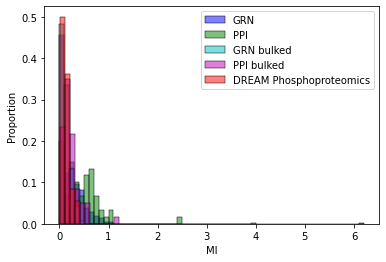

In [30]:
fig, ax = plt.subplots()
for a in [(GRN_MIs["MI"], "GRN", "b"), (no_GRN_MIs["MI"], "PPI", "g"),
          (bulked_GRN_MIs["MI"], "GRN bulked", "c"), (bulked_no_GRN_MIs["MI"], "PPI bulked", "m"),
          (DREAM_MI["MI"], "DREAM Phosphoproteomics", "r")]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.5, binwidth=0.1)
plt.legend()

In [31]:
print("Data PPI")
print(no_GRN_MIs["MI"].mean())
print(no_GRN_MIs["MI"].std())

print("Data GRN")
print(GRN_MIs["MI"].mean())
print(GRN_MIs["MI"].std())

print("Data PPI bulked")
print(bulked_no_GRN_MIs["MI"].mean())
print(bulked_no_GRN_MIs["MI"].std())

print("Data GRN bulked")
print(bulked_GRN_MIs["MI"].mean())
print(bulked_GRN_MIs["MI"].std())


print("DREAM MI")
print(DREAM_MI["MI"].mean())
print(DREAM_MI["MI"].std())

Data PPI
0.4429386057224389
0.3943515791222613
Data GRN
0.21419017229026865
0.30790278086420986
Data PPI bulked
0.2293689017967685
0.18069839181033276
Data GRN bulked
0.1206925186311469
0.16682746106983282
DREAM MI
0.12507782945895107
0.08836095560194193


# The same thing with Kendall's tau?

In [32]:
from scipy.stats import kendalltau

In [33]:
def compute_tau(node, network, values_df):
    """ Compute the mutual information between a node and 
    all of its parents according to the given network topology. """
    
    parents = [p for p in network.predecessors(node)]
    if len(parents) == 0:
        return(None)
    else:
        mi_dict = {}
        for i in range(len(parents)):
            try:
                mi_dict[parents[i]] = kendalltau(values_df[node], values_df[parents[i]])
            except Exception as e:
                print(e)
        return(mi_dict)




def compute_all_TAU(network_no_GRN, network_with_GRN, values_df):
    GRN_MIs = pd.DataFrame(columns = ["Node", "Parents", "TAU"])
    no_GRN_MIs = pd.DataFrame(columns = ["Node", "Parents", "TAU"])
    
    nodes_GRN = [n for n in network_with_GRN.nodes() if n not in network_no_GRN.nodes()]
    edges_GRN = [n for n in network_with_GRN.edges() if n not in network_no_GRN.edges()]
    
    index = 0
    for n in nodes_GRN:
        MI = compute_tau(n, network_with_GRN, values_df)
        if MI is not None:
            for p, mi in MI.items():
                GRN_MIs.loc[index, "Node"] = n
                GRN_MIs.loc[index, "Parents"] = p
                GRN_MIs.loc[index, "TAU"] = mi[0]
                index += 1
    
    index = 0
    for n in network_no_GRN.nodes():
        MI = compute_tau(n, network_no_GRN, values_df)
        if MI is not None:
            for p, mi in MI.items():
                no_GRN_MIs.loc[index, "Node"] = n
                no_GRN_MIs.loc[index, "Parents"] = p
                no_GRN_MIs.loc[index, "TAU"] = mi[0]
                index += 1
    
    return(GRN_MIs, no_GRN_MIs)

In [34]:
GRN_TAU, no_GRN_TAU = compute_all_TAU(network_no_GRN=G_noGRN, network_with_GRN=G_GRN, values_df=depth_norm)

'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'NFkB'
'AP1'
'AP1'
'NFkB'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'TRAF12'
'TRAF12'
'STAT35'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'TRAF12'
'TRAF12'
'TRAF23'
'TRAF23'
'TRAF23'
'STAT35'
'STAT35'
'STAT35'


In [35]:
def get_TAU_phosphoproteomics(phosphoproteomics_df, mapping_dict, prior_network):
    tau_dict_DREAM = {}
    for n in prior_network.nodes():
        if n in mapping_dict: # We only look at the nodes for which we can have the protein activity
            parents = [p for p in prior_network.predecessors(n)]
            print(n, parents)
            for i in range(len(parents)):
                node = mapping_dict[n]
                try:
                    # Do we have the expression for the parent?
                    parent = mapping_dict[parents[i]]
                    # Compute the MI
                    tau_dict_DREAM[(parent, node)] = kendalltau(phosphoproteomics_df[parent],
                                                               phosphoproteomics_df[node])
                except Exception as e:
                    print(e) 
    DREAM_TAU = pd.DataFrame.from_dict(tau_dict_DREAM, orient="index")
    DREAM_TAU.columns = ["TAU", "pval"]
    DREAM_TAU["parent"] = DREAM_TAU.index
    DREAM_TAU.reset_index()
    return(DREAM_TAU)

In [36]:
DREAM_TAU = get_TAU_phosphoproteomics(phosphoproteomics_df=proteom,
                                     mapping_dict=dico,
                                     prior_network=PPI_network)

PIP3 ['PTEN', 'PI3K']
unhashable type: 'list'
unhashable type: 'list'
AKT_S473 ['PIP3', 'mTOR']
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 372378
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 372378
p53 ['p38']
RB ['p53', 'GSK3B', 'AMPK']
GSK3B ['PKC', 'AKT']
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 372378
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 372378
AMPK ['SERUM']
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 372378
cleavedCas ['p53', 'SMAD23']
SMAD23 ['SERUM']
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 372378
ERK12 ['MEK12', 'FAK']
MSK12 ['ERK12', 'MKK36', 'p38']
All inputs to `kendalltau` must be of the same size, found x-size 372378 and y-size 0
All inputs to `kendalltau` must be of the same size, found x-size 372378 and y-size 0
All inputs to `kendalltau` must be of t

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4868: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 372378
CREB ['p90RSK', 'AKT', 'MAPKAPK2']
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 372378
RAS ['EGFR', 'ERK12']
unhashable type: 'list'
All inputs to `kendalltau` must be of the same size, found x-size 372378 and y-size 0
PI3K ['RAS', 'EGFR', 'INSR', 'MET']
unhashable type: 'list'
unhashable type: 'list'
unhashable type: 'list'
unhashable type: 'list'
BTK ['SRC', 'SYK']
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 372378
RAF_S259 ['AKT']
unhashable type: 'list'
MARCKS ['PKC']
unhashable type: 'list'
SRC ['EGFR', 'PI3K']
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 372378
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 372378
FAK ['SRC', 'MET']
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 372378
EGFR ['EGFR', 'EGF', 'SERUM']
unhashable type:

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/numpy/lib/histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


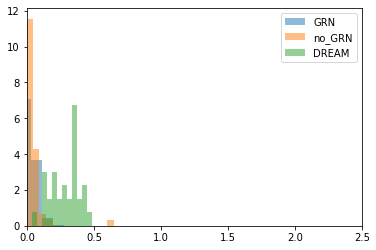

In [37]:
plt.hist(GRN_TAU["TAU"], density = True, alpha = 0.5,  label = "GRN", bins = 15)
plt.hist(no_GRN_TAU["TAU"], density = True, alpha = 0.5, label = "no_GRN", bins = 15)
plt.hist(DREAM_TAU["TAU"], density = True, alpha = 0.5, label = "DREAM", bins = 15)
plt.xlim([0,2.5])
plt.legend()
plt.show()

Text(0.5, 1.0, "Kendall's tau")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


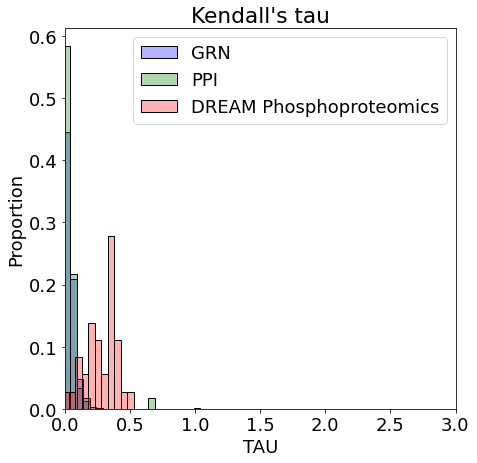

In [60]:
fig, ax = plt.subplots(figsize = (7.,7))
for a in [(GRN_TAU["TAU"], "GRN", "b"), (no_GRN_TAU["TAU"], "PPI", "g"),
          (DREAM_TAU["TAU"], "DREAM Phosphoproteomics", "r")]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.3, binwidth=0.05)
plt.xlim([0,3])
plt.legend()
plt.title("Kendall's tau")

In [39]:
bulked_GRN_TAU, bulked_no_GRN_TAU = compute_all_TAU(network_no_GRN=G_noGRN, network_with_GRN=G_GRN, values_df=bulked_df)

'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'NFkB'
'AP1'
'AP1'
'NFkB'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'TRAF12'
'TRAF12'
'STAT35'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'TRAF12'
'TRAF12'
'TRAF23'
'TRAF23'
'TRAF23'
'STAT35'
'STAT35'
'STAT35'


Text(0.5, 1.0, "Kendall's tau")

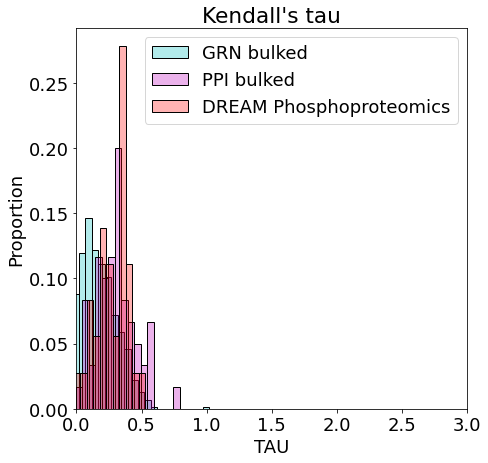

In [61]:
fig, ax = plt.subplots(figsize = (7.,7))
for a in [#(GRN_TAU["TAU"], "GRN", "b"), (no_GRN_TAU["TAU"], "PPI", "g"),
          (bulked_GRN_TAU["TAU"], "GRN bulked", "c"), (bulked_no_GRN_TAU["TAU"], "PPI bulked", "m"),
          (DREAM_TAU["TAU"], "DREAM Phosphoproteomics", "r")]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.3, binwidth=0.05)
plt.xlim([0,3])
plt.legend()
plt.title("Kendall's tau")

In [41]:
print("Data PPI")
print(no_GRN_TAU["TAU"].mean())
print(no_GRN_TAU["TAU"].std())

print("Data GRN")
print(GRN_TAU["TAU"].mean())
print(GRN_TAU["TAU"].std())

print("Data PPI bulked")
print(bulked_no_GRN_TAU["TAU"].mean())
print(bulked_no_GRN_TAU["TAU"].std())

print("Data GRN bulked")
print(bulked_GRN_TAU["TAU"].mean())
print(bulked_GRN_TAU["TAU"].std())



print("DREAM Tau")
print(DREAM_TAU["TAU"].mean())
print(DREAM_TAU["TAU"].std())

Data PPI
0.03339946129931765
0.09090663463038803
Data GRN
0.014994685109908078
0.06352344399181876
Data PPI bulked
0.29146532597486796
0.15795869057532821
Data GRN bulked
0.154329390038192
0.1500328693282466
DREAM Tau
0.25986234378037315
0.1378739188424363


PIP3 ['PTEN', 'PI3K']
unhashable type: 'list'
unhashable type: 'list'
AKT_S473 ['PIP3', 'mTOR']
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 34932
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 34932
p53 ['p38']
RB ['p53', 'GSK3B', 'AMPK']
GSK3B ['PKC', 'AKT']
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 34932
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 34932
AMPK ['SERUM']
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 34932
cleavedCas ['p53', 'SMAD23']
SMAD23 ['SERUM']
All inputs to `kendalltau` must be of the same size, found x-size 0 and y-size 34932
ERK12 ['MEK12', 'FAK']
MSK12 ['ERK12', 'MKK36', 'p38']
All inputs to `kendalltau` must be of the same size, found x-size 34932 and y-size 0
All inputs to `kendalltau` must be of the same size, found x-size 34932 and y-size 0
All inputs to `kendalltau` must be of the same 

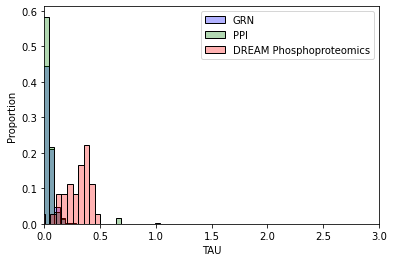

In [42]:
DREAM_TAU_60 = get_TAU_phosphoproteomics(phosphoproteomics_df=proteom[proteom["time"]==60],
                                     mapping_dict=dico,
                                     prior_network=PPI_network)
fig, ax = plt.subplots()
for a in [(GRN_TAU["TAU"], "GRN", "b"), (no_GRN_TAU["TAU"], "PPI", "g"),
          (DREAM_TAU_60["TAU"], "DREAM Phosphoproteomics", "r")]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.3, binwidth=0.05)
plt.xlim([0,3])
plt.legend()

In [43]:
# Pearson correlation
from scipy.stats import pearsonr

def compute_r(node, network, values_df):
    """ Compute the mutual information between a node and 
    all of its parents according to the given network topology. """
    
    parents = [p for p in network.predecessors(node)]
    if len(parents) == 0:
        return(None)
    else:
        mi_dict = {}
        for i in range(len(parents)):
            try:
                mi_dict[parents[i]] = pearsonr(values_df[node], values_df[parents[i]])
            except Exception as e:
                print(e)
        return(mi_dict)




def compute_all_r(network_no_GRN, network_with_GRN, values_df):
    GRN_MIs = pd.DataFrame(columns = ["Node", "Parents", "TAU"])
    no_GRN_MIs = pd.DataFrame(columns = ["Node", "Parents", "TAU"])
    
    nodes_GRN = [n for n in network_with_GRN.nodes() if n not in network_no_GRN.nodes()]
    edges_GRN = [n for n in network_with_GRN.edges() if n not in network_no_GRN.edges()]
    
    index = 0
    for n in nodes_GRN:
        MI = compute_r(n, network_with_GRN, values_df)
        if MI is not None:
            for p, mi in MI.items():
                GRN_MIs.loc[index, "Node"] = n
                GRN_MIs.loc[index, "Parents"] = p
                GRN_MIs.loc[index, "TAU"] = mi[0]
                index += 1
    
    index = 0
    for n in network_no_GRN.nodes():
        MI = compute_r(n, network_no_GRN, values_df)
        if MI is not None:
            for p, mi in MI.items():
                no_GRN_MIs.loc[index, "Node"] = n
                no_GRN_MIs.loc[index, "Parents"] = p
                no_GRN_MIs.loc[index, "TAU"] = mi[0]
                index += 1
    
    return(GRN_MIs, no_GRN_MIs)

def get_r_phosphoproteomics(phosphoproteomics_df, mapping_dict, prior_network):
    tau_dict_DREAM = {}
    for n in prior_network.nodes():
        if n in mapping_dict: # We only look at the nodes for which we can have the protein activity
            parents = [p for p in prior_network.predecessors(n)]
            print(n, parents)
            for i in range(len(parents)):
                node = mapping_dict[n]
                try:
                    # Do we have the expression for the parent?
                    parent = mapping_dict[parents[i]]
                    # Compute the MI
                    tau_dict_DREAM[(parent, node)] = pearsonr(phosphoproteomics_df[parent],
                                                               phosphoproteomics_df[node])
                except Exception as e:
                    print(e) 
    DREAM_TAU = pd.DataFrame.from_dict(tau_dict_DREAM, orient="index")
    DREAM_TAU.columns = ["TAU", "pval"]
    DREAM_TAU["parent"] = DREAM_TAU.index
    DREAM_TAU.reset_index()
    return(DREAM_TAU)

In [44]:
DREAM_r = get_r_phosphoproteomics(phosphoproteomics_df=proteom,
                                     mapping_dict=dico,
                                     prior_network=PPI_network)

PIP3 ['PTEN', 'PI3K']
unhashable type: 'list'
unhashable type: 'list'
AKT_S473 ['PIP3', 'mTOR']
unhashable type: 'list'
unhashable type: 'list'
p53 ['p38']
RB ['p53', 'GSK3B', 'AMPK']
GSK3B ['PKC', 'AKT']
unhashable type: 'list'
unhashable type: 'list'
AMPK ['SERUM']
unhashable type: 'list'
cleavedCas ['p53', 'SMAD23']
SMAD23 ['SERUM']
unhashable type: 'list'
ERK12 ['MEK12', 'FAK']
MSK12 ['ERK12', 'MKK36', 'p38']
unhashable type: 'list'
unhashable type: 'list'
unhashable type: 'list'
MKK36 ['ERK12']
H3 ['MSK12', 'p90RSK']
unhashable type: 'list'
p90RSK ['ERK12']
SERUM []
mTOR ['AMPK', 'GSK3B', 'AKT']
unhashable type: 'list'
unhashable type: 'list'
unhashable type: 'list'
AKT ['AKT_S473', 'AKT_T308']
unhashable type: 'list'
unhashable type: 'list'
NFkB ['AKT', 'PKA', 'PKC', 'MSK12']
unhashable type: 'list'
unhashable type: 'list'
unhashable type: 'list'
unhashable type: 'list'
cAMP ['SERUM']
unhashable type: 'list'
PKA ['cAMP']
unhashable type: 'list'
PKC ['PLCg2']
unhashable type: 'lis

/home/ubuntu/storage/miniconda3/envs/work/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


unhashable type: 'list'
EGF []
MEK12 ['MEK12_S221']
unhashable type: 'list'
STAT1 ['EGFR', 'p38']
unhashable type: 'list'
STAT3 ['EGFR', 'SRC']
unhashable type: 'list'


In [45]:
GRN_r, no_GRN_r = compute_all_r(network_no_GRN=G_noGRN, network_with_GRN=G_GRN, values_df=depth_norm)

'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'NFkB'
'AP1'
'AP1'
'NFkB'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'TRAF12'
'TRAF12'
'STAT35'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'TRAF12'
'TRAF12'
'TRAF23'
'TRAF23'
'TRAF23'
'STAT35'
'STAT35'
'STAT35'


In [46]:
bulked_GRN_r, bulked_no_GRN_r = compute_all_r(network_no_GRN=G_noGRN, network_with_GRN=G_GRN, values_df=bulked_df)

'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'NFkB'
'AP1'
'AP1'
'NFkB'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'AP1'
'TRAF12'
'TRAF12'
'STAT35'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'NFkB'
'TRAF12'
'TRAF12'
'TRAF23'
'TRAF23'
'TRAF23'
'STAT35'
'STAT35'
'STAT35'


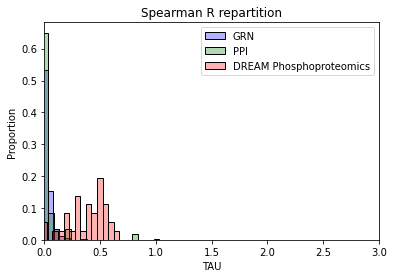

In [47]:
fig, ax = plt.subplots()
for a in [(GRN_r["TAU"], "GRN", "b"), (no_GRN_r["TAU"], "PPI", "g"),
          (DREAM_r["TAU"], "DREAM Phosphoproteomics", "r")]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.3, binwidth=0.05)
plt.xlim([0,3])
plt.title("Spearman R repartition")
plt.legend()

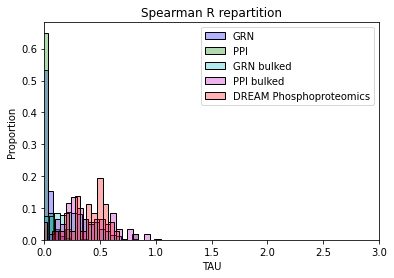

In [48]:
fig, ax = plt.subplots()
for a in [(GRN_r["TAU"], "GRN", "b"), (no_GRN_r["TAU"], "PPI", "g"),
          (bulked_GRN_r["TAU"], "GRN bulked", "c"), (bulked_no_GRN_r["TAU"], "PPI bulked", "m"),
          (DREAM_r["TAU"], "DREAM Phosphoproteomics", "r")]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.3, binwidth=0.05)
plt.xlim([0,3])
plt.title("Spearman R repartition")
plt.legend()

In [49]:
print("Data PPI")
print(no_GRN_TAU["TAU"].mean())
print(no_GRN_TAU["TAU"].std())

print("Data GRN")
print(GRN_TAU["TAU"].mean())
print(GRN_TAU["TAU"].std())

print("Data PPI bulked")
print(bulked_no_GRN_TAU["TAU"].mean())
print(bulked_no_GRN_TAU["TAU"].std())

print("Data GRN bulked")
print(bulked_GRN_TAU["TAU"].mean())
print(bulked_GRN_TAU["TAU"].std())

print("DREAM R")
print(DREAM_TAU["TAU"].mean())
print(DREAM_TAU["TAU"].std())

Data PPI
0.03339946129931765
0.09090663463038803
Data GRN
0.014994685109908078
0.06352344399181876
Data PPI bulked
0.29146532597486796
0.15795869057532821
Data GRN bulked
0.154329390038192
0.1500328693282466
DREAM R
0.25986234378037315
0.1378739188424363


The results are not what we expected for the MI: it doesn't seem like there is more signal in the DREAM dataset than in the PPI with the gene expression data. But the correlation coefficients make sense

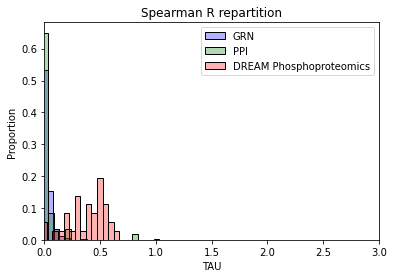

In [50]:
fig, ax = plt.subplots()
for a in [(GRN_r["TAU"], "GRN", "b"), (no_GRN_r["TAU"], "PPI", "g"),
          (DREAM_r["TAU"], "DREAM Phosphoproteomics", "r")]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.3, binwidth=0.05)
plt.xlim([0,3])
plt.title("Spearman R repartition")
plt.legend()

# Bulking the data improves the correlation distribution and makes it closer to that of the DREAM dataset

# Ascertaining time correlation in the DREAM dataset


In [51]:
(np.array(proteom["p.S6"]))

array([4.63975, 4.76504, 4.39714, ..., 3.6727 , 5.47626, 3.47342])

In [52]:
def get_MIs_phosphoproteomics_time(phosphoproteomics_df, mapping_dict, prior_network, timestep):
    time = list(np.unique(phosphoproteomics_df["time"]))
    mi_dict_DREAM = {}
    for i in range(1,len(time)):
        
        if (i+timestep) < len(time):
            df_t = phosphoproteomics_df[phosphoproteomics_df["time"] == time[i]]
            df_timestep = phosphoproteomics_df[phosphoproteomics_df["time"] == time[i+timestep]]
            common_cells = list(set(df_t["cellID"]) & set(df_timestep["cellID"]))
            
            # Keep only the cells in common between the times
            df_t = df_t[df_t["cellID"].isin(common_cells)]
            df_timestep = df_timestep[df_timestep["cellID"].isin(common_cells)]
            #print("t",df_t)
            #print("timestep",df_timestep)
            for n in prior_network.nodes():
                
                if n in mapping_dict: # We only look at the nodes for which we can have the protein activity
                    parents = [p for p in prior_network.predecessors(n)]
                    
                    for i in range(len(parents)):
                        node = mapping_dict[n]
                        
                        try:
                            # Do we have the expression for the parent?
                            parent = mapping_dict[parents[i]]
                            mi = float(mutual_info_regression(
                                    X = np.array(df_t[parent]).reshape(-1, 1), 
                                    y = np.array(df_timestep[node]), 
                                    random_state = 2))
                            print(mi)
                            # Compute the MI
                            mi_dict_DREAM[(parent, node, time[i])] = mi
                        except Exception as e:
                            print(e) 
    #print(mi_dict_DREAM)
    DREAM_MI = pd.DataFrame.from_dict(mi_dict_DREAM, orient="index")
    DREAM_MI.columns = ["MI"]
    DREAM_MI["parent"] = DREAM_MI.index
    DREAM_MI.reset_index()
    return(DREAM_MI)

In [53]:
#Look at the correlations for timesteps 1,2,3, just for EGF stimulation cellID <=5091
DREAM_0 = get_MIs_phosphoproteomics_time(phosphoproteomics_df=proteom_EGF[proteom_EGF["cellID"]<5092],
                                         mapping_dict=dico,
                                         prior_network=PPI_network,
                                         timestep=0)

NameError: name 'proteom_EGF' is not defined

In [ ]:
DREAM_1 = get_MIs_phosphoproteomics_time(phosphoproteomics_df=proteom_EGF[proteom_EGF["cellID"]<5092],
                                         mapping_dict=dico,
                                         prior_network=PPI_network,
                                         timestep=1)

In [ ]:
df = proteom_EGF[proteom_EGF["cellID"]<5092]
df[df["time"]==0]

In [ ]:

DREAM_2 = get_MIs_phosphoproteomics_time(phosphoproteomics_df=proteom_EGF[proteom_EGF["cellID"]<5092],
                                         mapping_dict=dico,
                                         prior_network=PPI_network,
                                         timestep=2)

In [ ]:

DREAM_3 = get_MIs_phosphoproteomics_time(phosphoproteomics_df=proteom_EGF[proteom_EGF["cellID"]<5092],
                                         mapping_dict=dico,
                                         prior_network=PPI_network,
                                         timestep=3)

In [ ]:

fig, ax = plt.subplots(figsize=(10,5))
for a in [(GRN_MIs["MI"], "GRN", "b"),
          (no_GRN_MIs["MI"], "PPI", "g"),
          (DREAM_0["MI"], "DREAM Phosphoproteomics ts = 0", "r"),
          (DREAM_1["MI"], "DREAM Phosphoproteomics ts = 1", "y"),
           (DREAM_2["MI"], "DREAM Phosphoproteomics ts = 2", "c"),
           (DREAM_3["MI"], "DREAM Phosphoproteomics ts = 3", "m")
          
         ]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.5, binwidth=0.05)
plt.legend()

In [ ]:
proteom["treatment"]

In [ ]:
proteom_iPKC = proteom[proteom["treatment"]=="iPKC"]
proteom_iPKC

In [ ]:
time_array = np.unique(proteom_EGF["time"])
for i in range(len(time_array)):
    print(max(proteom_EGF[proteom_EGF["time"]==time_array[i]]["cellID"]))
# 5091 is the lowest one

In [ ]:
def get_tau_phosphoproteomics_time(phosphoproteomics_df, mapping_dict, prior_network, timestep):
    time = list(np.unique(phosphoproteomics_df["time"]))
    tau_dict_DREAM = {}
    for i in range(1,len(time)):
        
        if (i+timestep) < len(time):
            df_t = phosphoproteomics_df[phosphoproteomics_df["time"] == time[i]]
            df_timestep = phosphoproteomics_df[phosphoproteomics_df["time"] == time[i+timestep]]
            common_cells = list(set(df_t["cellID"]) & set(df_timestep["cellID"]))
            
            # Keep only the cells in common between the times
            df_t = df_t[df_t["cellID"].isin(common_cells)]
            df_timestep = df_timestep[df_timestep["cellID"].isin(common_cells)]
            for n in prior_network.nodes():
                
                if n in mapping_dict: # We only look at the nodes for which we can have the protein activity
                    parents = [p for p in prior_network.predecessors(n)]
                    if parents != []:
                        for i in range(len(parents)):
                            node = mapping_dict[n]

                            try:
                                # Do we have the expression for the parent?
                                parent = mapping_dict[parents[i]]
                            except:
                                print("cannot find parent")
                            try:
                                print(parent)
                                print(df_t[parent])
                                tau = kendalltau(df_t[parent], df_timestep[node])
                                #print(tau)
                                # Compute the MI
                                tau_dict_DREAM[(parent, node, time[i])] = tau
                            except Exception as e:
                                print("")
                                #print(e) 
    #print(mi_dict_DREAM)
    DREAM_TAU = pd.DataFrame.from_dict(tau_dict_DREAM, orient="index")
    DREAM_TAU.columns = ["TAU", "PVAL"]
    DREAM_TAU["parent"] = DREAM_TAU.index
    DREAM_TAU.reset_index()
    return(DREAM_TAU)

In [ ]:
#Look at the correlations for timesteps 1,2,3, just for EGF stimulation cellID <=5091
DREAM_TAU_0 = get_tau_phosphoproteomics_time(phosphoproteomics_df=proteom_EGF[proteom_EGF["cellID"]<5092],
                                         mapping_dict=dico,
                                         prior_network=PPI_network,
                                         timestep=0)

In [ ]:
DREAM_TAU_1 = get_tau_phosphoproteomics_time(phosphoproteomics_df=proteom_EGF[proteom_EGF["cellID"]<5092],
                                         mapping_dict=dico,
                                         prior_network=PPI_network,
                                         timestep=1)

In [ ]:

DREAM_TAU_2 = get_tau_phosphoproteomics_time(phosphoproteomics_df=proteom_EGF[proteom_EGF["cellID"]<5092],
                                         mapping_dict=dico,
                                         prior_network=PPI_network,
                                         timestep=2)

In [ ]:

DREAM_TAU_3 = get_tau_phosphoproteomics_time(phosphoproteomics_df=proteom_EGF[proteom_EGF["cellID"]<5092],
                                         mapping_dict=dico,
                                         prior_network=PPI_network,
                                         timestep=3)

In [ ]:

fig, ax = plt.subplots(figsize=(10,5))
for a in [(GRN_TAU["TAU"], "GRN", "b"),
          (no_GRN_TAU["TAU"], "PPI", "g"),
          (DREAM_TAU_0["TAU"], "DREAM Phosphoproteomics ts = 0", "r")
          #,(DREAM_TAU_1["TAU"], "DREAM Phosphoproteomics ts = 1", "y")
           #,(DREAM_TAU_2["TAU"], "DREAM Phosphoproteomics ts = 2", "c")
           #,(DREAM_TAU_3["TAU"], "DREAM Phosphoproteomics ts = 3", "m")
          
         ]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.5, binwidth=0.05)
plt.legend()

In [ ]:

fig, ax = plt.subplots(figsize=(10,5))
for a in [(GRN_TAU["TAU"], "GRN", "b"),
          (no_GRN_TAU["TAU"], "PPI", "g")
          #,(DREAM_TAU_0["TAU"], "DREAM Phosphoproteomics ts = 0", "r")
          ,(DREAM_TAU_1["TAU"], "DREAM Phosphoproteomics ts = 1", "y")
           #,(DREAM_TAU_2["TAU"], "DREAM Phosphoproteomics ts = 2", "c")
           #,(DREAM_TAU_3["TAU"], "DREAM Phosphoproteomics ts = 3", "m")
          
         ]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.5, binwidth=0.05)
plt.legend()

In [ ]:

fig, ax = plt.subplots(figsize=(10,5))
for a in [(GRN_TAU["TAU"], "GRN", "b"),
          (no_GRN_TAU["TAU"], "PPI", "g")
          #,(DREAM_TAU_0["TAU"], "DREAM Phosphoproteomics ts = 0", "r")
          #,(DREAM_TAU_1["TAU"], "DREAM Phosphoproteomics ts = 1", "y")
           ,(DREAM_TAU_2["TAU"], "DREAM Phosphoproteomics ts = 2", "c")
           #,(DREAM_TAU_3["TAU"], "DREAM Phosphoproteomics ts = 3", "m")
          
         ]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.5, binwidth=0.05)
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for a in [(GRN_TAU["TAU"], "GRN", "b"),
          (no_GRN_TAU["TAU"], "PPI", "g")
          #,(DREAM_TAU_0["TAU"], "DREAM Phosphoproteomics ts = 0", "r")
          #,(DREAM_TAU_1["TAU"], "DREAM Phosphoproteomics ts = 1", "y")
           #,(DREAM_TAU_2["TAU"], "DREAM Phosphoproteomics ts = 2", "c")
           ,(DREAM_TAU_3["TAU"], "DREAM Phosphoproteomics ts = 3", "m")
          
         ]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.5, binwidth=0.05)
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
for a in [#(GRN_TAU["TAU"], "GRN", "b"),
          #(no_GRN_TAU["TAU"], "PPI", "g")
          (DREAM_TAU_0["TAU"], "DREAM Phosphoproteomics ts = 0", "r")
          ,(DREAM_TAU_1["TAU"], "DREAM Phosphoproteomics ts = 1", "y")
           ,(DREAM_TAU_2["TAU"], "DREAM Phosphoproteomics ts = 2", "c")
           ,(DREAM_TAU_3["TAU"], "DREAM Phosphoproteomics ts = 3", "m")
          
         ]:
    sns.histplot(a[0], ax=ax, stat = "proportion", label = a[1], color=a[2], alpha = 0.5, binwidth=0.05)
plt.legend()